# News Fetching and Summary

Note: based on this [Haystack Blog](https://haystack.deepset.ai/cookbook/hackernews-custom-component-rag).

We will implement a simple Haystack pipeline that includes news-fetching component and then an LLM will summarize the top 2 articles. The LLM will be implemented using an OPEA generator, an abstraction around hardware and serving, only exposing an endpoint, easily deployable anywhere.

Let's go, step by step!

## News Fetcher
First we'll create a custom component which will fetch news from Hacker News.

In [ ]:
!pip install newspaper3k
!pip install lxml[html_clean]

In [55]:
from typing import List
from haystack import component, Document
from newspaper import Article
import requests

In [56]:
@component
class HackernewsNewestFetcher():

  @component.output_types(articles=List[Document])
  def run(self, last_k: int):
    newest_list = requests.get(url='https://hacker-news.firebaseio.com/v0/newstories.json?print=pretty')
    articles = []
    for id in newest_list.json()[0:last_k]:
      article = requests.get(url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty")
      if 'url' in article.json():
        articles.append(article.json()['url'])

    docs = []
    for url in articles:
      try:
        article = Article(url)
        article.download()
        article.parse()
        docs.append(Document(content=article.text, meta={'title': article.title, 'url': url}))
      except:
        print(f"Couldn't download {url}, skipped")
    return {'articles': docs}

## LLM

We use the `OPEAGenerator`. It requires an endpoint, and optionally a model name and model options.

In [58]:
from haystack_opea import OPEAGenerator

llm = OPEAGenerator(
    "http://localhost:9009/v1",
    "Qwen/Qwen2.5-7B-Instruct",
    model_arguments={"max_tokens": 2000}
)

## Prompt

We introduce a prompt using the `PromptBuilder` component. Prompts are represented using jinja templating.

In [59]:
from haystack.components.builders.prompt_builder import PromptBuilder

In [60]:
prompt_template = """
You will be provided a few of the latest posts in HackerNews, followed by their URL.
For each post, provide a one sentence summary, followed by the original post URL.

Posts:
{% for article in articles %}
  {{article.meta['title']}}:
  {{article.content}}
  URL: {{article.meta['url']}}
{% endfor %}
"""

## Building the Pipeline

Building a pipeline is done by defining the components and then defining the connections.

In [66]:
from haystack import Pipeline

In [67]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()

In [68]:
pipe = Pipeline()
pipe.add_component("hackernews_fetcher", fetcher)
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("llm", llm)

In [69]:
pipe.connect("hackernews_fetcher.articles", "prompt_builder.articles")
pipe.connect("prompt_builder.prompt", "llm.prompt")

🚅 Components
  - hackernews_fetcher: HackernewsNewestFetcher
  - prompt_builder: PromptBuilder
  - llm: OPEAGenerator
🛤️ Connections
  - hackernews_fetcher.articles -> prompt_builder.articles (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

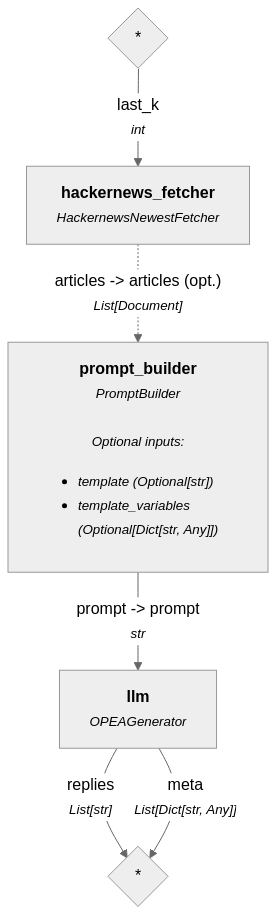

In [70]:
pipe.show()

# Run

In [ ]:
result = pipe.run(data={"hackernews_fetcher": {"last_k": 2}})

In [74]:
print(result['llm']['replies'][0])

The European Commission's new ProtectEU security strategy proposes enhanced tools for law enforcement, including methods to access encrypted data, raising significant concerns about potential violations of privacy and civil liberties.

[URL: https://www.cloudwards.net/news/protecteu-security-strategy-raises-encryption-concerns/]

A course on using Large Language Models (LLMs) to understand and structure search queries without relying on external services is being offered, demonstrating how LLMs can significantly improve and automate search capabilities.

[URL: https://softwaredoug.com/blog/2025/04/08/llm-query-understand]
